### Bidirectional Recurrent Neural Network using MNIST

![Bi-d RNN](tutorial_images/Bi-directional_RNN/Bi-directional_RNN.jpg)

In [1]:
#import packages
import matplotlib
matplotlib.use('Agg')
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist
from utils import get_mnist
from pyspark import SparkContext
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
#Create Spark Context
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","8g"))

init_engine()

Populating the interactive namespace from numpy and matplotlib
Prepending /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7/, and pyspark is found in: /home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


In [2]:
#Setting the path for Spark
os.environ['JAVA_HOME']="/usr/lib/jvm/java-8-oracle"
os.environ['SPARK_HOME'] = "/home/kunal/Downloads/spark-2.4.7-bin-hadoop2.7"
os.environ['HADOOP_HOME'] = "/usr/local/hadoop/bin"
os.environ['YARN_CONF_DIR'] = "/usr/local/hadoop/etc/hadoop"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /home/kunal/Downloads/jarfiles/bigdl-SPARK_2.2-0.7.0-jar-with-dependencies.jar --packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.3,org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.3 pyspark-shell'

In [3]:
# Get and store MNIST into RDD of Sample.
mnist_path = "./data/mnist"
(train_data, test_data) = get_mnist(sc, mnist_path)

train_data = train_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (28, 28)), s.label.to_ndarray()))
test_data = test_data.map(lambda s: Sample.from_ndarray(np.resize(s.features[0].to_ndarray(), (28, 28)), s.label.to_ndarray()))
print(train_data.count())
print(test_data.count())

Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
60000
10000


In [4]:
# Hyper Parameters
batch_size = 64
# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

In [5]:
#Bi-directional RNN model
def build_model(input_size, hidden_size, output_size):
    model = Sequential()
    recurrent = BiRecurrent(JoinTable(3, 3))
    recurrent.add(LSTM(input_size, hidden_size))
    model.add(InferReshape([-1, input_size], True))
    model.add(recurrent)
    model.add(Select(2, -1))
    model.add(Linear(2*hidden_size, output_size))
    return model
rnn_model = build_model(n_input, n_hidden, n_classes)

creating: createSequential
creating: createJoinTable
creating: createBiRecurrent
creating: createTanh
creating: createSigmoid
creating: createLSTM
creating: createInferReshape
creating: createSelect
creating: createLinear


In [6]:
# Create an Optimizer
criterion = CrossEntropyCriterion()
optimizer = Optimizer(
    model=rnn_model,
    training_rdd=train_data,
    criterion=criterion,
    optim_method=Adam(),
    end_trigger=MaxEpoch(5),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='rnn-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createCrossEntropyCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  rnn-20210104-170624


/home/kunal/anaconda3/envs/deep_learning/lib/python3.6/site-packages/bigdl/optim/optimizer.py:864: UserWarning: You are recommended to use `create` method to create an optimizer.
  warnings.warn("You are recommended to use `create` method to create an optimizer.")


In [7]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 16.9 ms, sys: 4.87 ms, total: 21.8 ms
Wall time: 3min 13s


### Loss visualization

In [8]:
#Tensorboard
%load_ext tensorboard
%tensorboard --logdir=/tmp/tmp1400sz2q

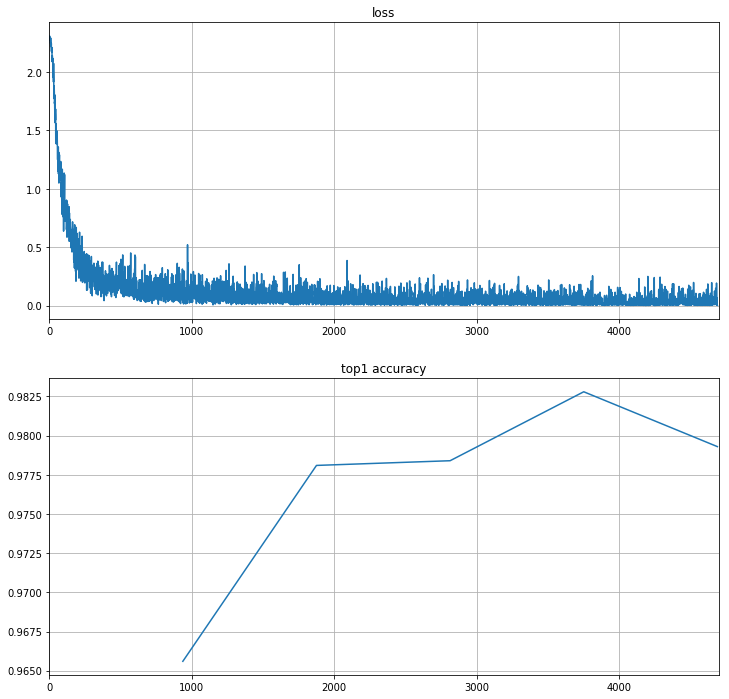

In [9]:
#Matplotlib
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)

### Prediction on test data

In [10]:
#Method for Label
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

Ground Truth labels:
7, 2, 1, 0, 4, 1, 4, 9
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 20.1 ms, sys: 3.95 ms, total: 24 ms
Wall time: 1.01 s


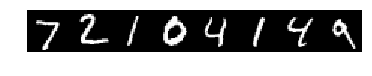

In [11]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features[0].to_ndarray()).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); plt.axis('off')
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(8)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(8)))